In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. Allostatic Load/P1012.3. Analyses/P1012.3.2. Ordinal Regression/Output')
cur_date = "060724"

library(readxl)
library(openxlsx)
library(tidyverse)
library(ordinalNet)
library(reshape2)
library(ggpubr)
library(themis)

# reading in file
bp_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_050824.xlsx", sheet = 4)) 
subject_info_df = data.frame(read_excel("Input/Subject_Info_050824.xlsx", sheet = 2))
mediator_scores_df = data.frame(read_excel("Input/Mediator_Scores_BP_Subjects_060724.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: recipes


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step




In [2]:
head(bp_df)
head(subject_info_df)
head(mediator_scores_df)

,Subject_ID,Systolic,Diastolic,BP_Classification
,<chr>,<dbl>,<dbl>,<chr>
1,CS_M_21_W_5,114,70,N
2,CS_M_24_W_8,118,71,N
3,CS_M_25_W_10,121,83,E
4,CS_M_28_W_16,115,74,N
5,CS_M_29_W_17,118,80,N
6,CS_F_31_B_21,112,77,N


,Study,Original_Subject_Number,Subject_ID,Subject_Number,Smoking_Status,Sex,Age,Race
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,FM2,97,CS_M_18_B_1,1,CS,M,18,B
2,FM2,99,CS_F_20_W_2,2,CS,F,20,W
3,FM2,101,CS_F_20_W_3,3,CS,F,20,W
4,FM2,98,CS_F_21_W_4,4,CS,F,21,W
5,TCORS LAIV,39,CS_M_21_W_5,5,CS,M,21,W
6,FM2,100,CS_F_22_W_6,6,CS,F,22,W


,Variable,Subject_ID,Mediator_Score
,<chr>,<chr>,<dbl>
1,Cortisol,CS_M_21_W_5,0.24743096
2,Cortisol,CS_M_24_W_8,0.31083055
3,Cortisol,CS_M_25_W_10,0.13144609
4,Cortisol,CS_M_28_W_16,0.06754252
5,Cortisol,CS_M_29_W_17,0.44649218
6,Cortisol,CS_F_31_B_21,0.21687581


In this analysis, we're using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 18 biomarkers. 

Starting by combining the dataframes.

In [3]:
# creating a vector for variables that increase atherosclerotic risk
# HDL decreases risk
allostatic_load_biomarkers = c('Cortisol','Noradrenaline','Epinephrine','Hba1c','Fibrinogen','CRP', 'HDL')

ordinal_regression = function(dataset){
    # add words!!!!!
    # creating 1 df
    ordinal_regression_df = inner_join(bp_df[,c(1,4)], subject_info_df[,3:8]) %>%
        # adding mediator scores data
        inner_join(dataset[,1:3]) %>%
        # obtaining allostatic load biomarkers only
        filter(Variable %in% allostatic_load_biomarkers) %>%
        pivot_wider(names_from = Variable, values_from = Mediator_Score)

    #reordering and removing some columns
    ordinal_regression_df = ordinal_regression_df[,c(1,8:14,2)]

    return(ordinal_regression_df)
    }

# calling fn
reg_df = ordinal_regression(mediator_scores_df)

head(reg_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


Subject_ID,Cortisol,Noradrenaline,Hba1c,Fibrinogen,CRP,HDL,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.24743096,0.9209663,0.06894884,0.23783025,0.017763222,0.29358611,0.09415997,N
CS_M_24_W_8,0.31083055,0.5018144,0.29255348,0.05082129,0.008710668,0.23290254,0.08473086,N
CS_M_25_W_10,0.13144609,0.8466564,0.64414592,0.26137633,0.060818954,0.02491066,0.36245167,E
CS_M_28_W_16,0.06754252,0.5018144,0.11121726,0.00000000,0.026508784,0.17484827,1.00000000,N
CS_M_29_W_17,0.44649218,0.3297612,0.28738359,0.18107212,0.016648117,0.52779975,0.72404411,N
CS_F_31_B_21,0.21687581,0.2711344,0.75504241,0.16931582,0.129876982,0.06673031,0.31548045,N


# Assessing Distributions

Looking at the distributions of blood pressure classifications and the mediator scores for each variable.

In [4]:
table(reg_df$BP_Classification)


 1  2  E  N 
 6  1  9 18 

The stage 1 and stage 2 classes are on the smaller side with 6 and 1 subject, respectively. There weren't enough observation of the stage 2 class to perform SMOTE; therefore, the hypertension classes (the elevated, stage 1 and 2) will be grouped together into `H` for hypertension.

In [5]:
two_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2"), "H", BP_Classification))

three_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2", "E"), "H", BP_Classification))

# turning BP into a factor
two_reg_df$BP_Classification = factor(two_reg_df$BP_Classification, levels = c("N", "E", "H"))
three_reg_df$BP_Classification = factor(three_reg_df$BP_Classification, levels = c("N", "H"))

In [6]:
table(two_reg_df$BP_Classification)
table(three_reg_df$BP_Classification)


 N  E  H 
18  9  7 


 N  H 
18 16 

Now assessing normality of the biomarkers using a shapiro wilk test.

In [7]:
# using a shapiro wilk test to assess normality
do.call(rbind.data.frame, apply(reg_df[,2:8], 2, shapiro.test))[,1:3] %>%
    # adding a column that clarifies whether or not a variable is normally distributed or not
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.7429965,2.411103e-06,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9351777,4.436357e-02,Shapiro-Wilk normality test,Non-normal
Hba1c,0.9603241,2.484953e-01,Shapiro-Wilk normality test,Normal
Fibrinogen,0.8901584,2.546482e-03,Shapiro-Wilk normality test,Non-normal
CRP,0.6714903,1.848939e-07,Shapiro-Wilk normality test,Non-normal
HDL,0.8326592,1.173812e-04,Shapiro-Wilk normality test,Non-normal
Epinephrine,0.9324863,3.697532e-02,Shapiro-Wilk normality test,Non-normal


The only variable that is normally distributed is Hba1c. Therefore, we'll perform a data transformation (pseudo log 2) to see if that helps.

In [13]:
pslog2_df = reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(pslog2_df)

Subject_ID,Cortisol,Noradrenaline,Hba1c,Fibrinogen,CRP,HDL,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.31895997,0.9418322,0.09619281,0.30781349,0.02540196,0.37137609,0.1298237,N
CS_M_24_W_8,0.39048120,0.5867065,0.37022397,0.07151733,0.01251242,0.30205876,0.1173371,N
CS_M_25_W_10,0.17816785,0.8849155,0.71733834,0.33499877,0.08517846,0.03549816,0.4462051,E
CS_M_28_W_16,0.09429353,0.5867065,0.15214092,0.00000000,0.03774597,0.23247445,1.0000000,N
CS_M_29_W_17,0.53255852,0.4111672,0.36444198,0.24009707,0.02382042,0.61145546,0.7857967,N
CS_F_31_B_21,0.28318193,0.3461165,0.81150589,0.22566464,0.17616570,0.09319548,0.3955898,N


In [9]:
do.call(rbind.data.frame, apply(pslog2_df[,2:8], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.8291083,9.879115e-05,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9530450,1.514515e-01,Shapiro-Wilk normality test,Normal
Hba1c,0.9695032,4.479052e-01,Shapiro-Wilk normality test,Normal
Fibrinogen,0.9404895,6.375442e-02,Shapiro-Wilk normality test,Normal
CRP,0.7209469,1.048238e-06,Shapiro-Wilk normality test,Non-normal
HDL,0.9079889,7.507847e-03,Shapiro-Wilk normality test,Non-normal
Epinephrine,0.9437510,7.978057e-02,Shapiro-Wilk normality test,Normal


Now we have 4 out of 7 variables that are normally distributed. Let's go ahead and run ordinal regression.

In [8]:
# need to use the pslog2 data
two_reg_df = two_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

three_reg_df = three_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(two_reg_df)

Subject_ID,Cortisol,Noradrenaline,Hba1c,Fibrinogen,CRP,HDL,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
CS_M_21_W_5,0.3994008,0.9574185,0.1325016,0.38715681,0.03618957,0.45562427,0.1760976,N
CS_M_24_W_8,0.4755842,0.6660353,0.4544117,0.09965519,0.01793960,0.38079455,0.1600646,N
CS_M_25_W_10,0.2365451,0.9144998,0.7801743,0.41683841,0.11793231,0.05032499,0.5322721,E
CS_M_28_W_16,0.1299998,0.6660353,0.2043172,0.00000000,0.05345333,0.30155773,1.0000000,N
CS_M_29_W_17,0.6159422,0.4968889,0.4483111,0.31045305,0.03396268,0.68836431,0.8365678,N
CS_F_31_B_21,0.3597257,0.4288033,0.8571895,0.29356429,0.23409133,0.12855140,0.4808750,N


# Ordinal Regression

Using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 18 biomarkers. 

In [10]:
# creating a vector of booleans that specifies whether or not the coefficient should be
# positive (TRUE) or negative (FALSE), only HDL will be negative
biomarker_coefficients = c(rep(TRUE, ncol(reg_df) - 2))

estimateOrdWeights <- function(dataset, response, coefficients_magnitude){
    # """
    # Creating a function to run ordinal regression to estimate ordinal weights of mediator data based
    # on blood pressure classification
    # :param (input): wide df with biomarker data, response variable, magnitude of the coefficients
    # :output: 1 df with the ordinal weights
    # """
    
    # setting seed for reproducibility
    set.seed(12)
    
    #get number of response levels
    NoBins <- length(unique(dataset[[response]]))

    #get number of features or slices
    noSlices <- ncol(dataset) - 2

    # HDL needs to be negative so we'll make all the values negative
    dataset$HDL = dataset$HDL * -1
    
    # obtaining the features and converting into a matrix
    feature_data <- as.matrix(dataset[,c(2:(ncol(dataset) - 1))])

    # ordinal regression
    # positiveID specifies whether or not each coefficient for each ind. variable should be constrained to be non-negative
    regression_model <- ordinalNet(feature_data, dataset[[response]], positiveID = coefficients_magnitude, 
                            # lambdaVals defines how quickly your coefficients drop to 0
                            # keeping it at 0 tries to minimize feature reduction
                            # maxiterout defines the number of iterations before it stops
                         lambdaVals = 0, maxiterOut = 150)
    testW <- regression_model$coefs[NoBins:(noSlices + NoBins - 1)]

    # rescaling the coefficients so that they sum to 1
    normalizer = 1/sum(testW)
    rescaled_weight <- testW * normalizer

    # adding the variable names back in 
    test_weights_df = data.frame(Variable = colnames(feature_data), Coefficient = rescaled_weight) %>%
        arrange(-Coefficient) 
    
    return(test_weights_df)
}

# calling fn
two_weights_df = estimateOrdWeights(two_reg_df, 'BP_Classification', biomarker_coefficients)
three_weights_df = estimateOrdWeights(three_reg_df, 'BP_Classification', biomarker_coefficients)

two_weights_df
three_weights_df

Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.5323710
Noradrenaline,0.1740116
Fibrinogen,0.1733724
Cortisol,0.1202450
Hba1c,0.0000000
CRP,0.0000000
HDL,0.0000000


Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.4883158
Cortisol,0.3303183
Fibrinogen,0.1222687
Noradrenaline,0.0590972
Hba1c,0.0000000
CRP,0.0000000
HDL,0.0000000


Based on the overall results with all 34 subjects, we can see that epinephrine had the largest (56%) contribution to blood pressure classification, while 3 variables were constrained to 0 having no impact on BP classification.????

# Allostatic Load Summation

Now that we have these weights from the ordinal regression, we'll calculate allostatic load scores for each subject using both the previously calculated mediator scores multiplied the ordinal weight for the 7 allostatic load biomarkers (cortisol, noradrenaline, epinephrine, HDL, Hba1c, fibrinogen, and CRP). The formula looks like...

Allostatic Load = Cortisol ordinal weight * Cortisol score + CRP ordinal weight * CRP score...

In [50]:
allostatic_load = function(weights_df){
    # add words!!
    
    # combining the mediator scores with the ordinal weights into one dataframe
    wider_weights_df = pivot_longer(pslog2_df[,1:8], cols = 2:8, names_to = "Variable") %>%
        dcast(Variable ~ Subject_ID, value.var = "value") %>% 
        inner_join(weights_df) %>%
        column_to_rownames("Variable")

    # multiplying the value of the mediator in each row by its respective ordinal
    # weight found in the last column
    multiplication_df = wider_weights_df %>%
        select(-Coefficient) %>%
        mutate(across(contains("_"), ~.x*wider_weights_df$Coefficient))

    # calculating allostatic load by summing by the columns
    allostatic_load_df = data.frame(Allostatic_Load = apply(multiplication_df, 2, sum)) %>%
        arrange(-Allostatic_Load) %>%
        rownames_to_column(var = "Subject_ID")
    
    return(allostatic_load_df)
    }

# calling fn
two_allostatic_df = allostatic_load(two_weights_df)
three_allostatic_df = allostatic_load(three_weights_df)

head(two_allostatic_df)

Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`


,Subject_ID,Allostatic_Load
,<chr>,<dbl>
1,NS_F_23_W_41,0.7321116
2,NS_F_27_B_50,0.6652528
3,NS_F_21_W_38,0.6577898
4,CS_M_28_W_16,0.6458030
5,NS_F_38_B_61,0.6405694
6,CS_M_29_W_17,0.5955469


Now testing for statistical differences based on sex and smoking status using a two way anova.

In [51]:
# adding in demographic info for each subject
two_anova_df = inner_join(two_allostatic_df, subject_info_df[,c(3,5,6,8)])
three_anova_df = inner_join(three_allostatic_df, subject_info_df[,c(3,5,6,8)])
head(two_anova_df)

# looking at counts for each variable
table(two_anova_df[,c(3,5)])

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


,Subject_ID,Allostatic_Load,Smoking_Status,Sex,Race
,<chr>,<dbl>,<chr>,<chr>,<chr>
1,NS_F_23_W_41,0.7321116,NS,F,W
2,NS_F_27_B_50,0.6652528,NS,F,B
3,NS_F_21_W_38,0.6577898,NS,F,W
4,CS_M_28_W_16,0.6458030,CS,M,W
5,NS_F_38_B_61,0.6405694,NS,F,B
6,CS_M_29_W_17,0.5955469,CS,M,W


              Race
Smoking_Status  B  W
            CS  8  9
            NS 11  6

In [56]:
# anova
two_anova_smoking_race = aov(Allostatic_Load ~ Smoking_Status * Race, data = two_anova_df)
three_anova_smoking_race = aov(Allostatic_Load ~ Smoking_Status * Race, data = three_anova_df)
two_anova_smoking_sex = aov(Allostatic_Load ~ Smoking_Status * Sex, data = two_anova_df)
three_anova_smoking_sex = aov(Allostatic_Load ~ Smoking_Status * Sex, data = three_anova_df)

summary(two_anova_smoking_race)
summary(three_anova_smoking_race)
summary(two_anova_smoking_sex)
summary(three_anova_smoking_sex)

                    Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status       1 0.0950 0.09496   3.490 0.0716 .
Race                 1 0.0102 0.01019   0.374 0.5452  
Smoking_Status:Race  1 0.0344 0.03442   1.265 0.2696  
Residuals           30 0.8164 0.02721                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status       1 0.1296 0.12964   4.791 0.0365 *
Race                 1 0.0094 0.00942   0.348 0.5596  
Smoking_Status:Race  1 0.0210 0.02100   0.776 0.3854  
Residuals           30 0.8117 0.02706                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status      1 0.0950 0.09496   3.656 0.0655 .
Sex                 1 0.0362 0.03617   1.392 0.2473  
Smoking_Status:Sex  1 0.0456 0.04560   1.756 0.1952  
Residuals          30 0.7792 0.02597                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status      1 0.1296 0.12964   4.879  0.035 *
Sex                 1 0.0137 0.01373   0.517  0.478  
Smoking_Status:Sex  1 0.0312 0.03124   1.175  0.287  
Residuals          30 0.7972 0.02657                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [53]:
# post hoc
#TukeyHSD(anova)

There are no statistically significant differences in allostatic load by smoking status (p value = 0.11), race (p value = 0.95), nor the interaction between the two variables (p value = 0.95). (Not sure why the p values for race are different in the boxplot vs. the `aov` function, but either way it's still insignificant.)???

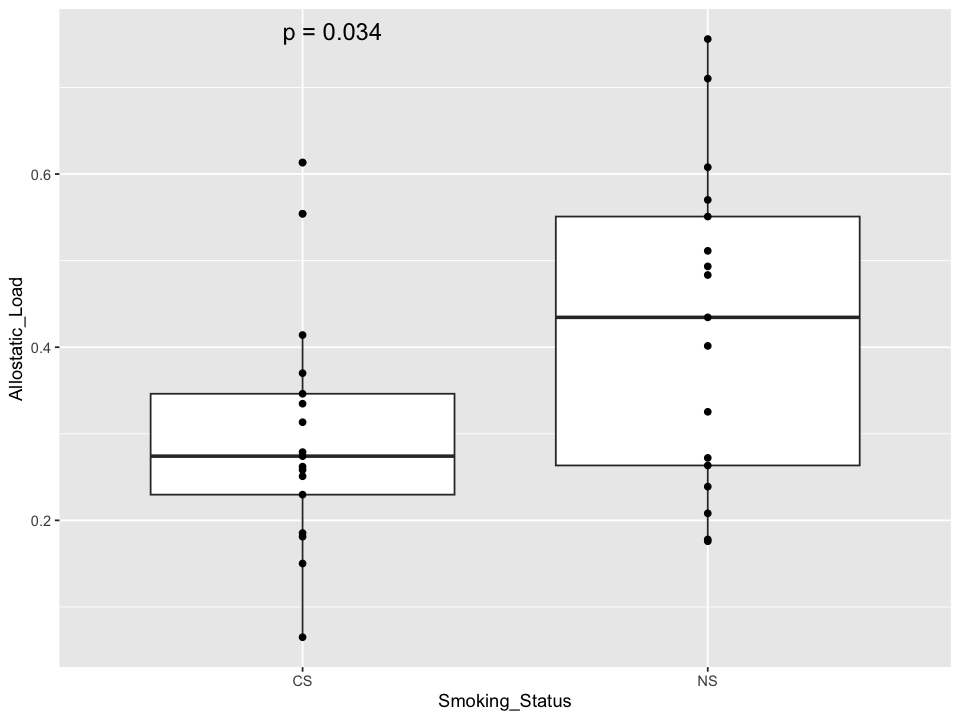

In [55]:
# visualizing using boxplots
options(repr.plot.width=8, repr.plot.height=6) #changing size

ggplot(data = three_anova_df, aes(y = Allostatic_Load, x = Smoking_Status)) + 
  geom_boxplot() +
  geom_point() + 

 stat_anova_test(wid = "Smoking_Status", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 5)

But why do NS have a higher allostatic load???